In [70]:
from collections import Counter
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import re
import pandas as pd
import numpy as np
import datetime as dt

## Load Databases

In [71]:
companies_df = pd.read_csv("/Users/jbpatty/project-3/companies.csv")

acquisitions_df = pd.read_csv("/Users/jbpatty/project-3/acquisitions.csv")

investments_df = pd.read_csv("/Users/jbpatty/project-3/investments.csv")

rounds_df = pd.read_csv("/Users/jbpatty/project-3/rounds.csv")

additions_df = pd.read_csv("/Users/jbpatty/project-3/additions.csv") 

## Clean Databases

### Company Database

In [249]:
companies_df.dtypes

permalink            object
name                 object
homepage_url         object
category_list        object
funding_total_usd    object
status               object
country_code         object
state_code           object
region               object
city                 object
funding_rounds        int64
founded_at           object
first_funding_at     object
last_funding_at      object
dtype: object

In [250]:
companies_df.shape

(66368, 14)

#### Remove companies that do not have a name

In [251]:
clean_companies_df = companies_df.dropna(subset = ['name'])
clean_companies_df.shape

(66367, 14)

#### Remove companies that do not have a first funding date

In [252]:
clean_companies_df = clean_companies_df.dropna(subset = ['first_funding_at'])
clean_companies_df.shape

(66343, 14)

#### Remove dates missing a year (year 1000 is just wrong) for both first and last funding date using raw string notation from Regex. Years will start with 19__ or 20__

In [253]:
clean_companies_df = clean_companies_df[clean_companies_df.first_funding_at.str.match(r'(19)|(20)')]

clean_companies_df = clean_companies_df[clean_companies_df.last_funding_at.str.match(r'(19)|(20)')]

clean_companies_df.shape

(66338, 14)

#### Adding datetime functionality 

In [254]:
clean_companies_df.first_funding_at = pd.to_datetime(clean_companies_df.loc[:, 'first_funding_at'])

clean_companies_df.last_funding_at = pd.to_datetime(clean_companies_df.loc[:, 'last_funding_at'])

clean_companies_df.dtypes

permalink                    object
name                         object
homepage_url                 object
category_list                object
funding_total_usd            object
status                       object
country_code                 object
state_code                   object
region                       object
city                         object
funding_rounds                int64
founded_at                   object
first_funding_at     datetime64[ns]
last_funding_at      datetime64[ns]
dtype: object

#### Convert funding total and funding rounds from objects to numeric values

In [255]:
# Convert '-' into NaN values
clean_companies_df.funding_total_usd.replace('-', np.nan, inplace=True)

# Convert object to numeric float values
clean_companies_df.funding_total_usd = pd.to_numeric(clean_companies_df.loc[:, 'funding_total_usd'])

# Convert NaN into 0
clean_companies_df["funding_total_usd"] = clean_companies_df["funding_total_usd"].fillna(0)

In [256]:
clean_companies_df.head()

,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
0,/organization/-fame,#fame,http://livfame.com,Media,10000000.0,operating,IND,16,Mumbai,Mumbai,1,NaN,2015-01-05,2015-01-05
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,700000.0,operating,USA,DE,DE - Other,Delaware City,2,2014-09-04,2014-03-01,2014-10-14
2,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,3406878.0,operating,NaN,NaN,NaN,NaN,1,NaN,2014-01-30,2014-01-30
3,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,2000000.0,operating,CHN,22,Beijing,Beijing,1,2007-01-01,2008-03-19,2008-03-19
4,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,0.0,operating,USA,IL,"Springfield, Illinois",Champaign,1,2010-01-01,2014-07-24,2014-07-24


In [257]:
# Convert object to numeric integer values
clean_companies_df.funding_rounds = pd.to_numeric(clean_companies_df.loc[:, 'funding_rounds'])

In [258]:
clean_companies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66338 entries, 0 to 66367
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   permalink          66338 non-null  object        
 1   name               66338 non-null  object        
 2   homepage_url       61280 non-null  object        
 3   category_list      63191 non-null  object        
 4   funding_total_usd  66338 non-null  float64       
 5   status             66338 non-null  object        
 6   country_code       59383 non-null  object        
 7   state_code         57794 non-null  object        
 8   region             58311 non-null  object        
 9   city               58313 non-null  object        
 10  funding_rounds     66338 non-null  int64         
 11  founded_at         51122 non-null  object        
 12  first_funding_at   66338 non-null  datetime64[ns]
 13  last_funding_at    66338 non-null  datetime64[ns]
dtypes: dat

#### Drop unncessary columns 

In [259]:
clean_companies_df.drop(columns=['homepage_url'], axis=1, inplace=True)

In [260]:
clean_companies_df.status.value_counts()

operating    53008
closed        6235
acquired      5548
ipo           1547
Name: status, dtype: int64

In [84]:
# See how many companies exited (acquired or IPO'd) more than 3 years ago
clean_companies_df[np.logical_and(
    np.logical_and(clean_companies_df.last_funding_at < pd.to_datetime('2013'),
                   clean_companies_df.first_funding_at > '2005'),
    np.logical_or(clean_companies_df.status == 'ipo',
                   clean_companies_df.status == 'acquired'))]

,permalink,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
20,/organization/1000-markets,1000 Markets,Art|E-Commerce|Marketplaces,500000.0,acquired,USA,WA,Seattle,Seattle,1,2009-01-01,2009-05-15,2009-05-15
23,/organization/1000memories,1000memories,Curated Web,2535000.0,acquired,USA,CA,SF Bay Area,San Francisco,2,2010-07-01,2010-01-01,2011-02-16
31,/organization/100plus,100Plus,Analytics,1250000.0,acquired,USA,CA,SF Bay Area,San Francisco,2,2011-09-16,2011-11-02,2011-11-30
32,/organization/1010data,1010data,Software,35000000.0,acquired,USA,NY,New York City,New York,1,2000-01-01,2010-03-08,2010-03-08
58,/organization/123people,yelster digital gmbh (former 123people),Local Search|Software|Web Design,0.0,acquired,AUT,9,Vienna,Vienna,1,2007-01-01,2008-01-01,2008-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66316,/organization/zuuka,zuuka!,Apps|Entertainment|Kids|Mobile|Publishing,0.0,acquired,USA,CA,Santa Barbara,Santa Barbara,2,2009-04-10,2011-01-24,2012-06-11
66321,/organization/zvents,Zvents,Concerts|Curated Web|Entertainment|Events|Kids...,55200000.0,acquired,USA,CA,SF Bay Area,San Mateo,4,2005-03-01,2005-10-05,2011-09-30
66336,/organization/zygo-corporation,Zygo Corporation,Manufacturing,9000000.0,acquired,USA,CT,CT - Other,Middlefield,1,NaN,2011-10-24,2011-10-24
66349,/organization/zyncro,Zyncro,Cloud Computing|Enterprise 2.0|Enterprise Soft...,3805520.0,acquired,ESP,56,Barcelona,Barcelona,2,2009-09-01,2011-04-05,2012-02-03


In [85]:
# See how many operating companies were last funded more than 3 years ago
clean_companies_df[np.logical_and(
    np.logical_and(clean_companies_df.last_funding_at < pd.to_datetime('2013'),
                   clean_companies_df.first_funding_at > '2005'),
    clean_companies_df.status == 'operating')]

,permalink,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
3,/organization/0-6-com,0-6.com,Curated Web,2000000.0,operating,CHN,22,Beijing,Beijing,1,2007-01-01,2008-03-19,2008-03-19
6,/organization/0ndine-biomedical-inc,Ondine Biomedical Inc.,Biotechnology,762851.0,operating,CAN,BC,Vancouver,Vancouver,2,1997-01-01,2009-09-11,2009-12-21
12,/organization/1-800-dentist,1-800-DENTIST,Health and Wellness,0.0,operating,USA,CA,Los Angeles,Los Angeles,1,1986-01-01,2010-08-19,2010-08-19
13,/organization/1-800-doctors,1-800-DOCTORS,Health and Wellness,1750000.0,operating,USA,NJ,Newark,Iselin,1,1984-01-01,2011-03-02,2011-03-02
17,/organization/10-20-media,10-20 Media,E-Commerce,2050000.0,operating,USA,MD,Baltimore,Woodbine,4,2001-01-01,2009-06-18,2011-12-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66339,/organization/zylie-the-bear,Zylie the Bear,E-Commerce,75000.0,operating,USA,CT,Hartford,Greenwich,1,2009-01-01,2012-06-07,2012-06-07
66346,/organization/zympi,Zympi,Mobile|Networking|Web Hosting,0.0,operating,USA,CA,Ontario - Inland Empire,Redlands,1,2010-09-03,2011-11-22,2011-11-22
66353,/organization/zyngenia,Zyngenia,Biotechnology,25000000.0,operating,USA,MD,"Washington, D.C.",Gaithersburg,1,2008-01-01,2010-09-09,2010-09-09
66359,/organization/zyrra,Zyrra,E-Commerce,1510500.0,operating,USA,MA,Boston,Cambridge,4,NaN,2010-10-21,2012-10-18


In [86]:
# See how many operating companies were closed more than 3 years ago
clean_companies_df[np.logical_and(
    np.logical_and(clean_companies_df.last_funding_at < pd.to_datetime('2013'),
                   clean_companies_df.first_funding_at > '2005'),
    clean_companies_df.status == 'closed')]

,permalink,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
34,/organization/10bestthings,10BestThings,Curated Web,50000.0,closed,USA,OH,Cleveland,Cleveland,1,2009-04-01,2009-04-01,2009-04-01
47,/organization/11i-solutions,11i Solutions,Enterprise Software,1800000.0,closed,USA,AL,Huntsville,Huntsville,1,NaN,2011-03-22,2011-03-22
76,/organization/169-st,169 ST.,Entertainment|Games,50000.0,closed,USA,FL,Orlando,Lake Mary,1,2009-05-15,2009-06-01,2009-06-01
88,/organization/1bib,1bib,Cars|Curated Web,0.0,closed,CHN,30,Guangzhou,Guangzhou,1,2006-01-01,2008-02-07,2008-02-07
89,/organization/1bog,One Block Off the Grid (1BOG),Clean Technology|Residential Solar,5000000.0,closed,USA,CA,SF Bay Area,San Francisco,1,2008-11-01,2010-02-11,2010-02-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66315,/organization/zuujit,Zuujit,E-Commerce,2700000.0,closed,USA,CA,Santa Barbara,Santa Barbara,1,2010-01-01,2010-04-30,2010-04-30
66318,/organization/zuvvu,Zuvvu,Advertising|Social Media Advertising|Social Me...,12000.0,closed,IND,9,Ahmedabad,Ahmadabad,1,2010-06-01,2011-11-01,2011-11-01
66335,/organization/zygo,Zygo Communications,Mobile|SMS,0.0,closed,GBR,H9,London,London,1,2005-06-21,2007-11-19,2007-11-19
66338,/organization/zykis,Zykis,Automotive|Data Security|Education|Kids|Portal...,800000.0,closed,USA,CA,Anaheim,Irvine,1,2006-10-27,2006-10-27,2006-10-27


In [291]:
# Create dataset containing only non-operting companies that closed or were acquired/IPO'd

current_date = clean_companies_df.last_funding_at.max()

nonoperating_companies_df = clean_companies_df[np.logical_or(
    clean_companies_df.status != 'operating',
    np.logical_and(
        np.logical_and(
            clean_companies_df.status == 'operating',
            clean_companies_df.first_funding_at >
            current_date - pd.offsets.DateOffset(years=10)),
        clean_companies_df.last_funding_at < current_date -
        pd.offsets.DateOffset(years=2, months=6)))].reset_index()

In [292]:
nonoperating_companies_df.drop(columns='index', axis=1, inplace=True)

In [293]:
nonoperating_companies_df.shape

(32426, 13)

In [294]:
# Create binary status column where 0 = closed, 1 = aqcquired/IPO'd
nonoperating_companies_df['status_bool'] = np.nan

# Fill the column
nonoperating_companies_df.loc[np.logical_or(
    nonoperating_companies_df.status == 'closed', nonoperating_companies_df.
    status == 'operating'), 'status_bool'] = 0
nonoperating_companies_df.loc[np.logical_or(
    nonoperating_companies_df.status == 'ipo', nonoperating_companies_df.status
    == 'acquired'), 'status_bool'] = 1

In [295]:
nonoperating_companies_df.status_bool.value_counts()

0.0    25331
1.0     7095
Name: status_bool, dtype: int64

In [296]:
# Number of companies that don't have funding dollar info
(nonoperating_companies_df['funding_total_usd'] == 0.0).sum()

6605

### Round Database

In [93]:
rounds_df.dtypes

company_permalink           object
company_name                object
company_category_list       object
company_country_code        object
company_state_code          object
company_region              object
company_city                object
funding_round_permalink     object
funding_round_type          object
funding_round_code          object
funded_at                   object
raised_amount_usd          float64
dtype: object

In [94]:
rounds_df.shape

(114949, 12)

In [95]:
rounds_df.funding_round_type.unique()

array(['venture', 'seed', 'undisclosed', 'equity_crowdfunding',
       'convertible_note', 'private_equity', 'debt_financing', 'angel',
       'grant', 'secondary_market', 'post_ipo_equity', 'post_ipo_debt',
       'product_crowdfunding', 'non_equity_assistance'], dtype=object)

In [96]:
# Only interested in pre exit and current funding rounds
clean_rounds_df = rounds_df[np.logical_and(
    rounds_df.funding_round_type !=  'post_ipo_equity',
    rounds_df.funding_round_type != 'post_ipo_debt')]

In [97]:
clean_rounds_df.shape

(114159, 12)

In [98]:
clean_rounds_df.funded_at = pd.to_datetime(clean_rounds_df.loc[:, 'funded_at'])

/Users/jbpatty/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


#### Average time between funding rounds

In [99]:
# Sort rounds by company name and dates
clean_rounds_df.sort_values(by=['company_name', 'funded_at'], ascending=True,inplace=True)

<ipython-input-99-3bdc978b4c0e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_rounds_df.sort_values(by=['company_name', 'funded_at'], ascending=True,inplace=True)


In [100]:
# Create column for time between funding rounds
clean_rounds_df['time_between_next_round'] = clean_rounds_df.groupby('company_name').funded_at.diff()

<ipython-input-100-5a4c37da082f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_rounds_df['time_between_next_round'] = clean_rounds_df.groupby('company_name').funded_at.diff()


In [101]:
# Calculate average time between rounds and average amount raised
average_round_time_amount = clean_rounds_df.groupby('company_name').agg({
    'time_between_next_round': pd.Series.mean,
    'raised_amount_usd' : 'mean'
}).rename(columns = {
         'time_between_next_round' : 'avg_time_between_rounds',
         'raised_amount_usd' : 'avg_raised_usd'
          }).reset_index()

In [297]:
# Merge into nonoperating companies df
nonoperating_companies_df = nonoperating_companies_df.merge(
                             average_round_time_amount, how='left', left_on='name', right_on='company_name')

In [298]:
average_round_time_amount

,company_name,avg_time_between_rounds,avg_raised_usd
0,"#BratPackStyle, LLC.",NaT,NaN
1,#HASHOFF,246 days,477500.0
2,#fame,NaT,10000000.0
3,#waywire,NaT,1750000.0
4,&TV Communications,111 days,2000000.0
...,...,...,...
65832,İş kutusu video ajansı,NaT,100000.0
65833,Еnso.fm,NaT,27838.0
65834,​Shwrüm,NaT,50000.0
65835,​WestEd,NaT,3000000.0


#### Time between first and second rounds

In [299]:
# Create a column in nonoperating companies df
nonoperating_companies_df['time_between_first_rounds'] = dt.timedelta(0)

for company in clean_rounds_df.company_name.unique():
    if len(clean_rounds_df[clean_rounds_df.company_name ==
                           company].funded_at) > 1:
        nonoperating_companies_df.loc[
            nonoperating_companies_df.name ==
            company, 'time_between_first_rounds'] = clean_rounds_df[
                clean_rounds_df.company_name == company].funded_at.values[
                    1] - clean_rounds_df[clean_rounds_df.company_name ==
                                         company].funded_at.values[0]



In [300]:
nonoperating_companies_df.to_pickle('/Users/jbpatty/project-3/nonoperating_companies_df.to_pickle')

#### Look at the distribution of features so see if there are any that dominate

In [108]:
with open('/Users/jbpatty/project-3/nonoperating_companies_df.to_pickle') as read_file:
    nonoperating_companies_df = pickle.load(read_file)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

In [301]:
# Fill empty categories with 'unknown'
nonoperating_companies_df.category_list.fillna('unknown', inplace=True)
# Create column with list of categories
nonoperating_companies_df['categories_list'] = nonoperating_companies_df.category_list.apply(str.split, sep='|')

#### Look at distribution of categories

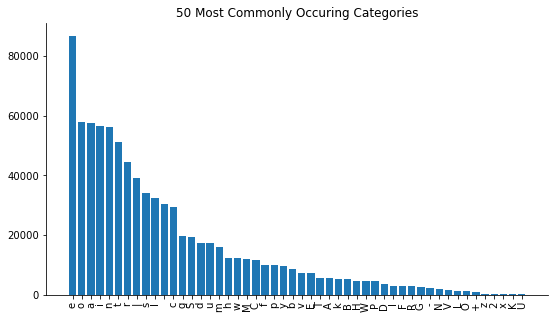

In [302]:
# Create list of category lists
categories = list(nonoperating_companies_df.category_list)
# Flatten the list
flat_categories = [cat for sublist in categories for cat in sublist]
# Count occurances of each
category_counts = Counter(flat_categories).most_common()
# Look at the distribution
plt.figure(figsize=(9, 5))
plt.bar([x[0] for x in category_counts[0:50]],
        [x[1] for x in category_counts[0:50]],
        width=0.8)
plt.xticks(rotation=90)
plt.title('50 Most Commonly Occuring Categories')
sns.despine()

In [303]:
# Take the top 25
top_categories = [x[0] for x in category_counts[0:25]]                       

#### For each company with a category in the top 25, replace its category_list with that single category

In [304]:
nonoperating_companies_df.categoty_list = nonoperating_companies_df.category_list.map(
    lambda x: list(set(x) & set(top_categories))
    if set(x) & set(top_categories) else ['0_other_categories'])

<ipython-input-304-689abd59d56a>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  nonoperating_companies_df.categoty_list = nonoperating_companies_df.category_list.map(


#### Check out category distribution with simplified categories

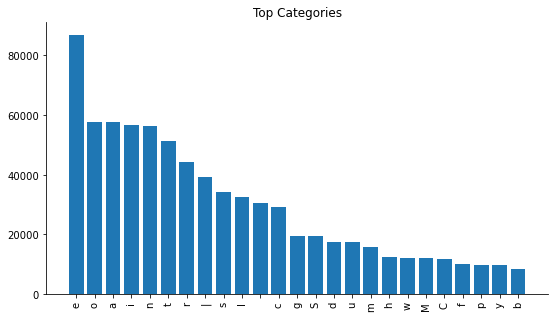

In [305]:
# Create list of category lists
categories = list(nonoperating_companies_df.category_list)
# Flatten the list
flat_categories = [cat for sublist in categories for cat in sublist]
# Count occurances of each
category_counts = Counter(flat_categories).most_common()
# Look at the distribution
plt.figure(figsize=(9, 5))
plt.bar([x[0] for x in category_counts[0:25]],
        [x[1] for x in category_counts[0:25]],
        width=0.8)
plt.xticks(rotation=90)
plt.title('Top Categories')
sns.despine()

In [306]:
category_counts[:5]

[('e', 86678), ('o', 57738), ('a', 57506), ('i', 56595), ('n', 56168)]

In [308]:
# Create dummy variables in the feature matrix
nonoperating_companies_df.category_list = nonoperating_companies_df.category_list.apply(
    lambda x: x[0])

### Location of features

In [309]:
# Country
nonoperating_companies_df.country_code.fillna('unknown', inplace=True)

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

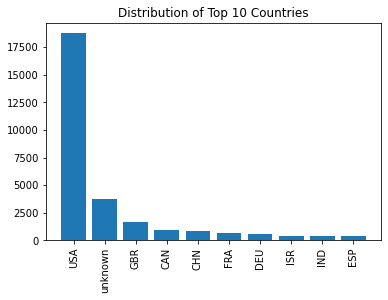

In [310]:
# Checkout distribution
country_dist = nonoperating_companies_df.groupby(
    'country_code').size().sort_values(ascending=False)
plt.bar(country_dist[0:10].index, height=country_dist[0:10].values)
plt.xticks(rotation=90)
plt.title('Distribution of Top 10 Countries')
sns.despine

In [311]:
# Countries with more than 500 companies
top_countries = nonoperating_companies_df.groupby('country_code').size() > 500

# Companies from countries with less than 500 go to 'other'
nonoperating_companies_df[
    'country'] = nonoperating_companies_df.country_code.apply(
    lambda x: x if top_countries[x] else '0_other_country')

In [312]:
# Check out states since most of the companies are US based
# Fill empty states with 'unknown'
nonoperating_companies_df.state_code.fillna('unknown', inplace=True)               

Text(0.5, 1.0, 'Distribution of Top 10 States')

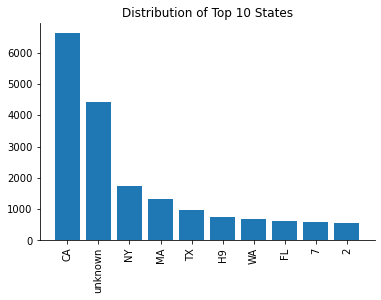

In [313]:
# Check out state distribution
state_dist = nonoperating_companies_df.groupby(
    'state_code').size().sort_values(ascending=False)
plt.bar(state_dist[0:10].index, height=state_dist[0:10].values)
plt.xticks(rotation=90)
sns.despine()
plt.title('Distribution of Top 10 States')

In [314]:
# States with more than 500 companies
top_states = nonoperating_companies_df.groupby('state_code').size() > 500

# Companies from states with less than 500 go to 'other'
nonoperating_companies_df[
    'state'] = nonoperating_companies_df.state_code.apply(
    lambda x: x if top_states[x] else '0_other_state')

In [315]:
nonoperating_companies_df[nonoperating_companies_df.funding_rounds == 1].status.value_counts()

operating    14661
closed        4794
acquired      2664
ipo            646
Name: status, dtype: int64

### Seed Round

Compare labeled seed rounds and labeled venture rounds to no seed rounds and unlabeled venture rounds

In [316]:
def seed_code(row):
    
    """
    Replace funding round type with 'seed' if type is 'seed'
    
    """
    
    if row['funding_round_type'] == 'seed':
        return 'seed'
    else:
        return row['funding_round_code']

clean_rounds_df['round_code'] = clean_rounds_df.apply(seed_code, axis=1)

<ipython-input-316-0385bb0c438a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_rounds_df['round_code'] = clean_rounds_df.apply(seed_code, axis=1)


In [317]:
clean_rounds_df.funded_at = pd.to_datetime(clean_rounds_df.loc[:, 'funded_at'])

/Users/jbpatty/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [318]:
# Group by company and round code for companies that segmented their rounds
company_round_groups = clean_rounds_df.groupby(['company_name',
                                                'round_code']).agg({
                                                'funded_at' : 'max',
                                                'raised_amount_usd':'sum'
                                              })
company_round_groups.reset_index(inplace=True)

In [319]:
# Seed df
seed_df = company_round_groups[company_round_groups.round_code == 'seed'].rename(
                        columns = {
                            'company_name' : 'name',
                            'round_code' : 'seed_bool',
                            'funded_at' : 'seed_date',
                            'raised_amount_usd' : 'seed_amount'
                        })

seed_df.seed_bool = 1

In [320]:
# Fill in seed bool column in df for companies with a labeled seed round
nonoperating_companies_df['seed_bool'] = 0
nonoperating_companies_df.loc[nonoperating_companies_df.isin(seed_df.name.values), 'seed_bool'] = 1

SystemError: <built-in method view of numpy.ndarray object at 0x7fe4ee92be90> returned a result with an error set

In [334]:
nonoperating_companies_df.seed_bool.value_counts()

0    32426
Name: seed_bool, dtype: int64

In [323]:
nonoperating_companies_df

,permalink,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,...,last_funding_at,status_bool,company_name,avg_time_between_rounds,avg_raised_usd,time_between_first_rounds,categories_list,country,state,seed_bool
0,/organization/0-6-com,0-6.com,C,2000000.0,operating,CHN,22,Beijing,Beijing,1,...,2008-03-19,0.0,0-6.com,NaT,2000000.00,0 days,[Curated Web],CHN,0_other_state,0
1,/organization/0ndine-biomedical-inc,Ondine Biomedical Inc.,B,762851.0,operating,CAN,BC,Vancouver,Vancouver,2,...,2009-12-21,0.0,Ondine Biomedical Inc.,101 days 00:00:00,381425.50,101 days,[Biotechnology],CAN,0_other_state,0
2,/organization/1-2-3-listo,"1,2,3 Listo",E,40000.0,operating,CHL,12,Santiago,Las Condes,1,...,2013-02-18,0.0,"1,2,3 Listo",NaT,40000.00,0 days,[E-Commerce],0_other_country,0_other_state,0
3,/organization/1-4-all,1-4 All,E,0.0,operating,USA,NC,NC - Other,Connellys Springs,1,...,2013-04-21,0.0,1-4 All,NaT,NaN,0 days,"[Entertainment, Games, Software]",USA,0_other_state,0
4,/organization/1-800-dentist,1-800-DENTIST,H,0.0,operating,USA,CA,Los Angeles,Los Angeles,1,...,2010-08-19,0.0,1-800-DENTIST,NaT,NaN,0 days,[Health and Wellness],USA,CA,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32421,/organization/zyraz-technology,Zyraz Technology,B,15419877.0,closed,MYS,14,MYS - Other,Damansara New Village,4,...,2013-02-15,0.0,Zyraz Technology,624 days 00:00:00,3854969.25,619 days,[Biotechnology],0_other_country,0_other_state,0
32422,/organization/zyrra,Zyrra,E,1510500.0,operating,USA,MA,Boston,Cambridge,4,...,2012-10-18,0.0,Zyrra,242 days 16:00:00,377625.00,25 days,[E-Commerce],USA,MA,0
32423,/organization/zystor,Zystor,B,8500000.0,acquired,USA,WI,Milwaukee,Milwaukee,1,...,2004-12-16,1.0,Zystor,NaT,8500000.00,0 days,[Biotechnology],USA,0_other_state,0
32424,/organization/zytoprotec,Zytoprotec,B,2686600.0,operating,AUT,3,Vienna,Gerasdorf Bei Wien,1,...,2013-01-29,0.0,Zytoprotec,NaT,2686600.00,0 days,[Biotechnology],0_other_country,0_other_state,0


### Fix 0 Values (should be nans)

In [325]:
# Convert 0 values to NaNs
nonoperating_companies_df.time_between_first_rounds.replace(to_replace=dt.timedelta(days=0),
                                   value=np.nan,
                                   inplace=True)

In [326]:
nonoperating_companies_df.columns

Index(['permalink', 'name', 'category_list', 'funding_total_usd', 'status',
       'country_code', 'state_code', 'region', 'city', 'funding_rounds',
       'founded_at', 'first_funding_at', 'last_funding_at', 'status_bool',
       'company_name', 'avg_time_between_rounds', 'avg_raised_usd',
       'time_between_first_rounds', 'categories_list', 'country', 'state',
       'seed_bool'],
      dtype='object')

### Clean up date info

In [327]:
# Convert timedelta columns to float values for classification models
nonoperating_companies_df['float_avg_time_between_rounds'] = nonoperating_companies_df.avg_time_between_rounds.dt.days
nonoperating_companies_df['float_time_between_first_rounds'] = nonoperating_companies_df.time_between_first_rounds.dt.days

In [333]:
nonoperating_companies_df.columns

Index(['permalink', 'name', 'category_list', 'funding_total_usd', 'status',
       'country_code', 'state_code', 'region', 'city', 'funding_rounds',
       'founded_at', 'first_funding_at', 'last_funding_at', 'status_bool',
       'company_name', 'avg_time_between_rounds', 'avg_raised_usd',
       'time_between_first_rounds', 'categories_list', 'country', 'state',
       'seed_bool', 'float_avg_time_between_rounds',
       'float_time_between_first_rounds'],
      dtype='object')

In [ ]:
df = nonoperating_companies_df

### Outliers

In [ ]:
# Store initial size of dataset
init_size = df.shape

In [ ]:
df.describe()

The max value for several of the columns is very suspicious for time between rounds and amount ($) raised

In [ ]:
plt.subplots(1, 4, figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.boxplot(
    df.float_time_between_first_rounds[df.float_time_between_first_rounds.notnull()])
plt.title('Time between first rounds')
plt.subplot(1, 4, 2)
plt.boxplot(df.float_avg_time_between_rounds[df.float_avg_time_between_rounds.notnull()])
plt.title('Average time between rounds')
plt.subplot(1, 4, 3)
plt.boxplot(df.avg_raised_usd[df.avg_raised_usd.notnull()])
plt.title('Average Raise Amount')
plt.subplot(1, 4, 4)
plt.boxplot(df.funding_total_usd[df.funding_total_usd.notnull()])
plt.title('Total Raise Amount')

Skewed heavily to the right - can try to cut out some of the outliers

In [ ]:
def findOutliers(df, column, lim_scalar=1.5):
    """
    Returns outliers above the max limit for a column in a dataframe
    Adjust outlier cutoff to q75 + 4*iqr to include more data
    ---
    input: DataFrame, column(series),lim_scalar(float)
    output: DataFrame
    """
    q25, q50, q75 = df[column].quantile(q=[0.25, 0.5, 0.75])
    iqr = q75 - q25
    # max limits to be considered an outlier
    max = q75 + lim_scalar * iqr
    # identify the points
    outlier_mask = [True if x > max else False for x in df[column]]
    print(
        '{} outliers found out of {} data points, {:.2f}% of the data'.format(
            sum(outlier_mask), len(df[column]),
            100 * (sum(outlier_mask) / len(df[column]))))
    return outlier_mask

In [ ]:
print('Funding total $: ')
fund_total_outlier_mask = pd.Series(
    findOutliers(df, 'funding_total_usd', lim_scalar=3))
print('Average round $: ')
avg_raise_outlier_mask = pd.Series(
    findOutliers(df, 'avg_raised_usd', lim_scalar=3))
print('Time between first rounds: ')
first_time_outlier_mask = pd.Series(
    findOutliers(df, 'float_time_between_first_rounds', lim_scalar=1.5))
print('Average time between rounds: ')
avg_time_outlier_mask = pd.Series(
    findOutliers(df, 'float_avg_time_between_rounds', lim_scalar=1.5))

Lots of overlap on these points. Remove the outliers

In [ ]:
# Take out outliers
clean_df1 = df[~fund_total_outlier_mask]
clean_df2 = df[~avg_raise_outlier_mask]
clean_df3 = df[~first_time_outlier_mask]
clean_df4 = df[~avg_time_outlier_mask]

clean_df = clean_df1.merge(clean_df2,
                           left_on=list(df.columns),
                           right_on=list(df.columns),
                           how='inner')
clean_df = clean_df.merge(clean_df3,
                          left_on=list(df.columns),
                          right_on=list(df.columns),
                          how='inner')
clean_df = clean_df.merge(clean_df4,
                          left_on=list(df.columns),
                          right_on=list(df.columns),
                          how='inner')

In [ ]:
print('Removed {} outliers, {:.2f}% of the original dataset'.format(
    (init_size[0] - clean_df.shape[0]), 100 *
    ((init_size[0] - clean_df.shape[0]) / (init_size[0] + clean_df.shape[0]))))

In [ ]:
clean_df.describe()

In [ ]:
clean_df.head()